# Solar Dynamo Model

In [1]:
from julia.api import Julia
jpath = "/Applications/Julia-1.9.app/Contents/Resources/julia/bin/julia" 
jl = Julia(runtime=jpath, compiled_modules=False) 
import julia 
from julia import Pkg
#Pkg.activate("/Users/Carlo/sbi/SolarDynamoModel")
Pkg.activate("/Users/albertca/sbi/SolarDynamoModel")
# Pkg.instantiate()
# from julia import Main
# Main.include("/Users/albertca/sbi/SolarDynamoModel/src/SolarDynamoModel.jl")
from julia import SolarDynamoModel

In [7]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [8]:

from sbi import utils
from sbi import analysis
from sbi import inference
from sbi.inference import SNPE, SNLE, simulate_for_sbi, prepare_for_sbi

seed = 0
torch.manual_seed(seed)

/Users/albertca/miniconda3/envs/sbi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
num_dim = 7
low = [0.1, 0.1, 1.0, 0.01, 1.0, 0.01, 0.0]
high = [15.0, 15.0, 15.0, 0.6, 15.0, 0.6, 6.28]
#τ, T, Nd, sigma, Bmax, eps, phi 
prior = utils.BoxUniform(low=low, high=high)

In [10]:
from sbi.utils.user_input_checks import process_simulator


simulator = process_simulator(SolarDynamoModel.sn,prior,1)

In [13]:
class SummaryNet(nn.Module):
    
    def __init__(self,
                 in_channels = (1, 8, 16),
                 out_channels = (8, 16, 32),
                 kernel_sizes =  (6, 4, 2), 
                 padding = (0,0,0),
                 encoded_space_dim = 8, 
                 drop_p = 0.5,
                 act = nn.LeakyReLU,
                 seq_length = 929,
                 linear = 128,
                ):
        """
        Convolutional Network with three convolutional and two dense layers
        Args:
            in_channels : inputs channels
            out_channels : output channels
            kernel_sizes : kernel sizes
            padding : padding added to edges
            encoded_space_dim : dimension of encoded space
            drop_p : dropout probability
            act : activation function
            seq_len : length of input sequences 
            weight_decay : l2 regularization constant
            linea : linear layer units
        """
        super().__init__()
    
        # Retrieve parameters
        self.in_channels = in_channels #tuple of int, input channels for convolutional layers
        self.out_channels = out_channels #tuple of int, of output channels 
        self.kernel_sizes = kernel_sizes #tuple of tuples of int kernel size, single integer or tuple itself
        self.padding = padding
        self.encoded_space_dim = encoded_space_dim
        self.drop_p = drop_p
        self.act = act
        self.seq_length = seq_length
        self.linear = linear 
        self.pool_division = 4
 
      
        ### Network architecture
        # First convolutional layer (2d convolutional layer
        self.first_conv = nn.Sequential(
            nn.Conv1d(self.in_channels[0], self.out_channels[0], self.kernel_sizes[0], padding=self.padding[0]), 
            #nn.BatchNorm1d(self.out_channels[0]),
            self.act(inplace = True),
            nn.Dropout(self.drop_p, inplace = False),
            nn.AvgPool1d(self.pool_division)
        )
        
        # Second convolution layer
        self.second_conv = nn.Sequential(
            nn.Conv1d(self.in_channels[1], self.out_channels[1], self.kernel_sizes[1], padding=self.padding[1]), 
            #nn.BatchNorm1d(self.out_channels[1]),
            self.act(inplace = True),
            nn.Dropout(self.drop_p, inplace = False),
            nn.AvgPool1d(self.pool_division)
        )
        
        # Third convolutional layer
        self.third_conv = nn.Sequential(
            nn.Conv1d(self.in_channels[2], self.out_channels[2], self.kernel_sizes[2], padding=self.padding[2]), 
            #nn.BatchNorm1d(self.out_channels[2]),
            self.act(inplace = True),
            nn.Dropout(self.drop_p, inplace = False),
            nn.AvgPool1d(self.pool_division)
        )


        # Flatten layer
        self.flatten = nn.Flatten(start_dim=-2)
        
        # Liner dimension after 2 convolutional layers
        self.lin_dim = int((((self.seq_length-self.kernel_sizes[0]+1)/self.pool_division+1-self.kernel_sizes[1])/self.pool_division+1-self.kernel_sizes[2])/self.pool_division)
        
        # linear encoder
        self.encoder_lin= nn.Sequential(
                # First linear layer
                nn.Linear(self.out_channels[2]*self.lin_dim, self.linear),
                #nn.BatchNorm1d(self.linear),
                self.act(inplace = True),
                nn.Dropout(self.drop_p, inplace = False),
                # Second linear layer
                nn.Linear(self.linear, self.encoded_space_dim)
            )
        # # normalizing latent space layer
        #self.normalize_enc = nn.BatchNorm1d(self.encoded_space_dim)



    def forward(self, x):
        x =x.view(-1,1,929)
        #x = x.unsqueeze(1)
        # else:
        
        # Apply first convolutional layer
        # x =x.view(-1,1,self.seq_length)
        x = self.first_conv(x)
        
        # Apply second convolutional layer
        # x =x.view(-1,8,int((self.seq_length-self.kernel_sizes[0]+1)/self.pool_division))
        x = self.second_conv(x)
        
        # Apply third conv layer
        # x =x.view(-1,16,int(((self.seq_length-self.kernel_sizes[0]+1)/self.pool_division+1-self.kernel_sizes[1])/self.pool_division))
        x = self.third_conv(x)
        
        # Flatten 
        # x = x.view(-1,32,int((((self.seq_length-self.kernel_sizes[0]+1)/self.pool_division+1-self.kernel_sizes[1])/self.pool_division+1-self.kernel_sizes[2])/self.pool_division))
        x = self.flatten(x)

        #print(x.shape)
        # Apply linear encoder layer
        x = self.encoder_lin(x)
        
        # # normalizing latent space layer
        # x = x.view(-1,1,256)
        #x = self.normalize_enc(x)
        #x = F.sigmoid(x) # output in [0,1]
        return x.view(-1,8)
        #return x.squeeze()
    


In [14]:
embedding_net = SummaryNet()

In [108]:
# input_size = 929
# num_classes = 7

# class SummaryNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # 1D convolutional layer
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
#         # Maxpool layer
#         self.pool = nn.MaxPool1d(kernel_size=10, stride = 10)
#         # Fully connected layer
#         self.fc = nn.Linear(in_features=6 * (input_size // 10), out_features=num_classes)

#     def forward(self, x):
#         # Assuming x is of shape (batch_size, 1, input_size)
#         x =x.view(-1,1,input_size)
#         x = self.conv1(x)
#         x = self.pool(x)
#         # Flatten the output before passing it to the fully connected layer
#         x = x.view(-1,6*(input_size // 10))
#         x = self.fc(x)
#         return x

# embedding_net = SummaryNet()


In [15]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [16]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)

Running 2000 simulations.: 100%|██████████| 2000/2000 [00:20<00:00, 99.97it/s] 


In [17]:
density_estimator = inference.append_simulations(theta, x).train()

 Neural network successfully converged after 365 epochs.

In [18]:
posterior = inference.build_posterior(density_estimator)

In [19]:
x_o = SolarDynamoModel.sn([10,5,5,0.1,5,0.1,3])  #τ, T, Nd, sigma, Bmax, eps, phi 

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase ~/.julia/packages/SciMLBase/szsYq/src/performance_warnings.jl:32


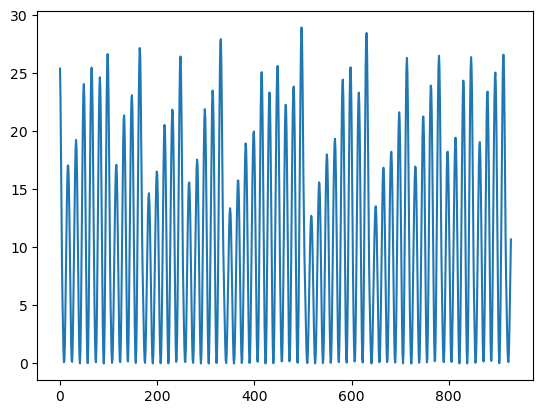

In [20]:
plt.plot(x_o)

In [ ]:
low = [0.1, 0.1, 1.0, 0.01, 1.0, 0.01, 0.0]
high = [15.0, 15.0, 15.0, 0.6, 15.0, 0.6, 6.28]

Drawing 1000 posterior samples: 1205it [00:00, 75090.80it/s]            


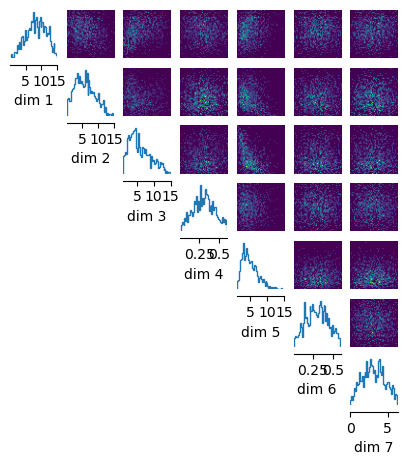

In [72]:
posterior_samples = posterior.sample((1000,), x=x_o)
_ = analysis.pairplot(
    posterior_samples, limits=[[0.1,15.0],[0.1,15.0],[1,15],[0.01,0.6],[1,15],[0.01,0.6],[0,6.28]], figsize=(5, 5)
)

/Users/albertca/miniconda3/envs/sbi_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/albertca/miniconda3/envs/sbi_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/albertca/miniconda3/envs/sbi_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/albertca/miniconda3/envs/sbi_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

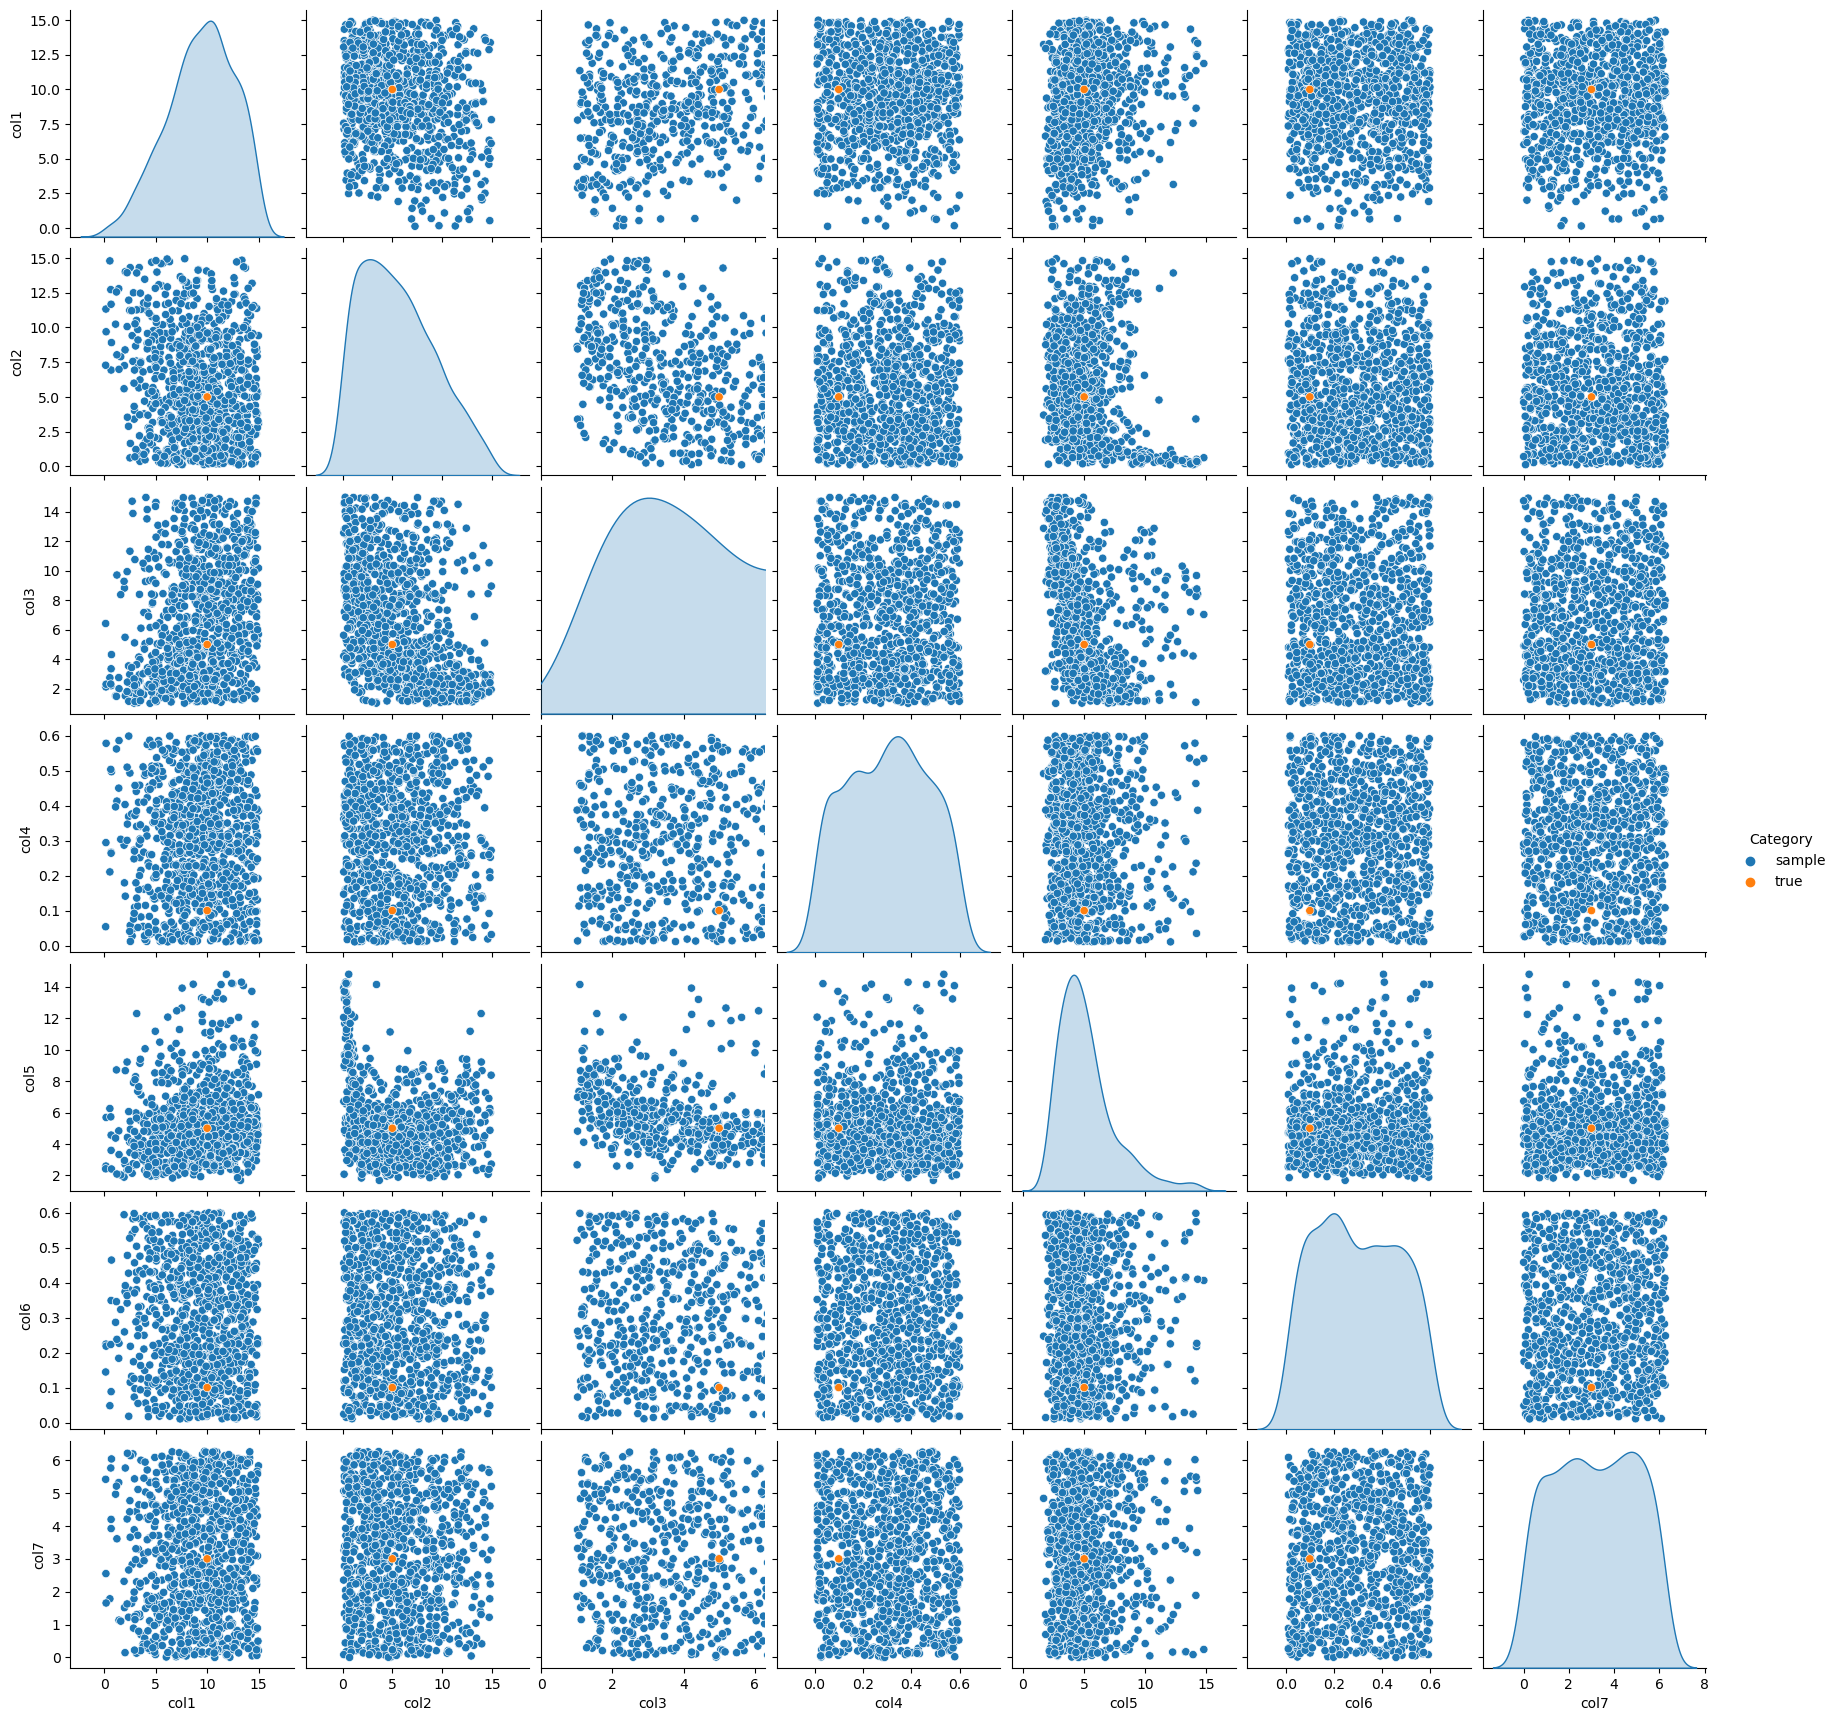

In [79]:
import pandas as pd
import numpy as np

# Assuming posterior_samples is a numpy array with shape (n_samples, 7)

sample_df = pd.DataFrame(posterior_samples, columns=[f'col{i}' for i in range(1, 8)])

# Generating true data
true_data = [10, 5, 5, 0.1, 5, 0.1, 3]
true_df = pd.DataFrame([true_data], columns=[f'col{i}' for i in range(1, 8)], index=['true'])

# Concatenating the two dataframes
result_df = pd.concat([sample_df, true_df])

result_df.insert(0, 'Category', ['sample'] * 1000 + ['true'])

# Display the resulting DataFrame
g = sns.pairplot(result_df, hue="Category")

g.axes[0,2].set_xlim((0.1,15.0))
g.axes[1,2].set_xlim((0.1,15.0))
g.axes[2,2].set_xlim((1,15))
g.axes[3,2].set_xlim((0.01,0.6))
g.axes[4,2].set_xlim((1,15))
g.axes[5,2].set_xlim((0.01,0.6))
g.axes[6,2].set_xlim((0,6.28))

plt.show()

In [73]:
proposal = posterior.set_default_x(x_o)

In [74]:
theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000)

Drawing 2000 posterior samples: 2304it [00:00, 74691.62it/s]            
Running 2000 simulations.: 100%|██████████| 2000/2000 [00:19<00:00, 101.12it/s]


In [75]:
density_estimator = inference.append_simulations(
        theta, x, proposal=proposal).train()

Using SNPE-C with atomic loss
 Neural network successfully converged after 87 epochs.

In [76]:
posterior = inference.build_posterior(density_estimator)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]WARNING:root:Only 0.218% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    976 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
Drawing 1000 posterior samples: 1011it [00:01, 556.38it/s]                         


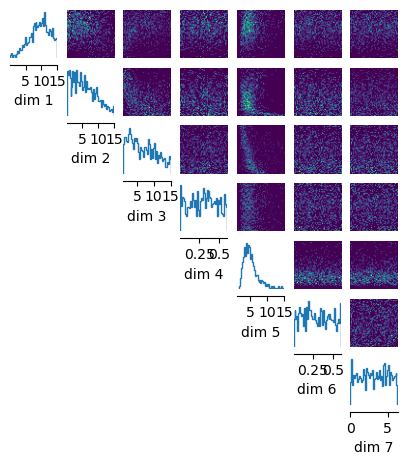

In [78]:
posterior_samples = posterior.sample((1000,), x=x_o)
_ = analysis.pairplot(
    posterior_samples, limits=[[0.1,15.0],[0.1,15.0],[1,15],[0.01,0.6],[1,15],[0.01,0.6],[0,6.28]], figsize=(5, 5)
)

In [81]:
rounds = 3
num_sims = 2000
inference = SNLE(prior)
proposal = prior
for _ in range(rounds):
    theta = proposal.sample((num_sims,))
    x = simulator(theta)
    _ = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior().set_default_x(x_o)
    proposal = posterior

RuntimeError: The size of tensor a (7) must match the size of tensor b (929) at non-singleton dimension 1

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

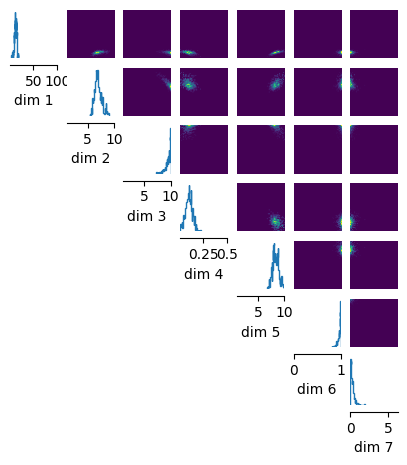

In [23]:
posterior_samples = posterior.sample((500,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[1.0,100.0],[1.0,10.0],[1,10],[0.01,0.5],[1,10],[0,1],[0,6.2]], figsize=(5, 5)
)

In [41]:
posteriorMeans = posterior_samples.mean(dim=0)
print(posteriorMeans)

tensor([8.2153, 5.8248, 5.6451, 0.3044, 4.8891, 0.3096, 3.1027])
